# Hypothesis Testing

Using various hypotheses from [Ideas & Hypothesis](https://docs.google.com/spreadsheets/d/15yBqDRTcaXI7R88JRcvbHJnZWMTMC6LUwJX3k7OD4Jc/edit#gid=0) spreadsheet.

## Initializing/Reading files

In [168]:
import os, itertools, csv, ast
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from tqdm import tqdm

#### Emotion and sentiment data has been aggregated by the mean, sum, and max. In our hypothesis testing, we will loop through these and just focus on the relevant correlations for those aggregation methods.

In [169]:
emo_agg = ["mean","sum","max"]

#### Helge provided aggregated code. The data is split into in-migration and out-migration. For each date period, the each unique location has an entry—with imputed zeroes for countries that originally did not have a datapoint.

In [170]:
dir = "Helge_code"
inMigration_file = "Sudan_states_inmigration_2023-10-12.csv"
outMigration_file = "Sudan_states_outmigration_2023-10-12.csv"

with open(os.path.join(dir, inMigration_file),"r") as f1, \
    open(os.path.join(dir, outMigration_file),"r") as f2:
    in_m = pd.read_csv(f1).rename(columns={"to":"location"})
    out_m = pd.read_csv(f2).rename(columns={"from":"location"})
in_m["date_later"] = pd.to_datetime(in_m["date_later"])
out_m["date_later"] = pd.to_datetime(out_m["date_later"])
in_m["flow"] = "IN"
out_m["flow"] = "OUT"

#### Given the aforementioned imputation of zero-rows, this code provides the ability to remove any rows that are entirely zeroes.

In [171]:
remove_0_rows = False

In [172]:
def rm_0_rows(df):
    return df[~(df[df.columns[2:]] == 0).all(axis=1)]

if remove_0_rows:
    in_m = rm_0_rows(in_m)
    out_m = rm_0_rows(out_m)

#### We are also interested in performing lead-lag analyses. This code provides a function that takes as input the dataframe for which we want to shift time, and the time-delta td by which we want to shift. Note, because the migration data is at a roughly-weekly granularity, we must shift by a matching time unit. The list output below contains all values on the scale on which we shift.

In [173]:
def time_shift(df, td, date_col = "date_later", val_col = "val", loc_col = "location"):
    dates = list(df[date_col].unique())
    def shift(date):
        if dates.index(date)+td < 0 or dates.index(date)+td >= len(dates):
            return "08/11/2024"
        else:
            return dates[dates.index(date)+td]

    left = df[[date_col,val_col,loc_col]].copy()
    right = df[[elem for elem in df.columns if elem!=val_col]].copy()
    right[date_col] = pd.to_datetime(right[date_col].apply(shift))
    return pd.merge(left, right, on = [date_col,loc_col], how = "inner").drop(columns = [date_col,loc_col])

print(sorted([pd.to_datetime(date).strftime('%m/%d/%Y') for date in in_m['date_later'].unique()]))

['04/27/2023', '05/05/2023', '05/12/2023', '05/21/2023', '05/29/2023', '06/04/2023', '06/08/2023', '06/14/2023', '06/21/2023', '06/28/2023', '07/05/2023', '07/12/2023', '07/23/2023', '07/27/2023', '08/04/2023', '08/10/2023']


#### We will focus a lot on the correlation between variables. This code takes two sets of columns that we want to compare and returns a correlation matrix for each pair of values—one from each column.

In [174]:
def corrMat(cols, idx, df):
    corrMat = pd.DataFrame(columns=cols, index=idx)
    for c2 in cols:
        for c1 in idx:
            corrMat.at[c1, c2] = df[c2].corr(df[c1])
    return corrMat

## Hypothesis 1: Positive Sentiment mostly captures joy
#### Author: Helge
#### Test: correlation (e.g., point-biseral) between each emotion and sentiment
#### Evidence Against: Low correlation between joy and sentiment. High correlation between other emotions and sentiment.

We are interested in comparing emotions and sentiment, so we can just get those columns. We choose multiBERT and GloVe for the respective labeling models.

In [175]:
senti_model = "multiBERT"
emo_model = "GloVe"

h1_in = in_m[["location"]+[col for col in in_m.columns if senti_model in col or emo_model in col]]
h1_out = out_m[["location"]+[col for col in out_m.columns if senti_model in col or emo_model in col]]
h1_df = pd.concat([h1_in, h1_out])
h1_df

,location,sentiment_multiBERT_mean,anger_GloVe_mean,fear_GloVe_mean,sadness_GloVe_mean,disgust_GloVe_mean,joy_GloVe_mean,anger-disgust_GloVe_mean,sentiment_multiBERT_sum,anger_GloVe_sum,...,disgust_GloVe_sum,joy_GloVe_sum,anger-disgust_GloVe_sum,sentiment_multiBERT_max,anger_GloVe_max,fear_GloVe_max,sadness_GloVe_max,disgust_GloVe_max,joy_GloVe_max,anger-disgust_GloVe_max
0,Aj Jazirah,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Aj Jazirah,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Aj Jazirah,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Aj Jazirah,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Aj Jazirah,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,White Nile,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
284,White Nile,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
285,White Nile,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
286,White Nile,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


For each unique location, as well as overall, we get the correlation between aggregation techniques for sentiment versus emotions.

In [176]:
h1_senti = sorted([col for col in h1_df.columns if senti_model in col])
h1_emo = sorted([col for col in h1_df.columns if emo_model in col])

h1_corrMats = {loc: corrMat(h1_emo, h1_senti, df) for loc, df in h1_df.groupby("location")}
h1_corrMats["all"] = corrMat(h1_emo, h1_senti, h1_df)

We can then choose which location subset we want to focus on, and get the correlation matrices for each aggreagation method. We put Joy first in the columns, as we are interested in how joy performs relative to other emotions.

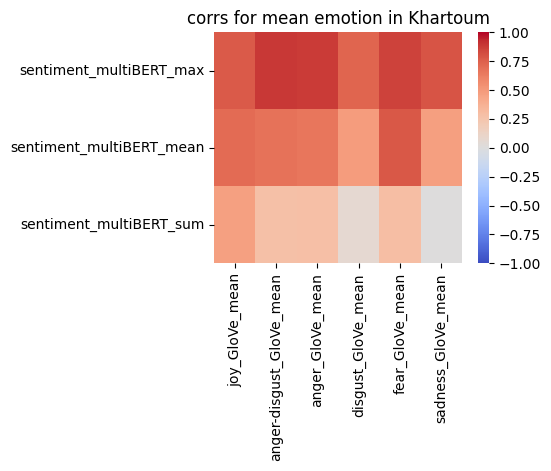

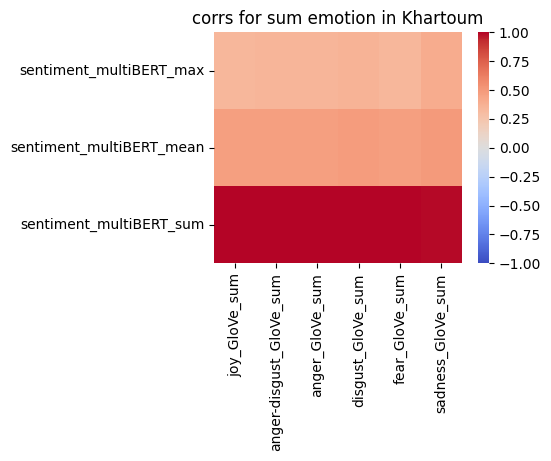

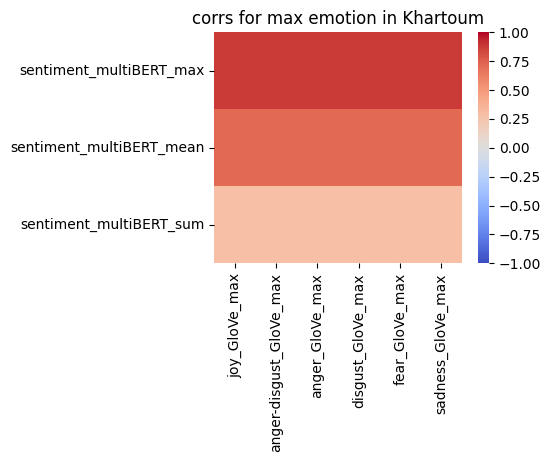

In [177]:
options = ["all"]+list(h1_df["location"].unique())

def output_h1(df, i, agg = ""):
    for agg in emo_agg:
        columns = sorted([col for col in df.columns if agg in col])
        joy = [col for col in columns if "joy" in col]
        ow = [col for col in columns if col not in joy]

        plt.figure(figsize=(4, 3))
        sns.heatmap(df[joy+ow].astype(float), annot=False, cmap='coolwarm', vmin=-1, vmax=1)   
        plt.title(f'corrs for {agg} emotion in {options[i]}')
        plt.show()

i=7
output_h1(h1_corrMats[options[i]], i, "mean")

NB: This analysis is for Khartoum specifically, but captures how we could draw conclusions for other locations.

Across all three aggregation methods, we see that emotion and sentiment have correlation >= 0 (no blue tiles). Given that high sentiment value mean more positive sentiment, our observation implies that the presence of any emotion either does not have any bearing on sentiment, or only implies some degree of positive sentiment.

For our emotion aggregation methods, we do not see a lot of evidence in support of our hypothesis. With max and sum emotions, we see consistent correlation values for each emotion within each sentiment aggregation method. For mean emotion, the max sentiment correlations show anger-disgust, anger, and fear being most correlated to maximum sentiment.

## Hypothesis 2: Fear will correlate mostly closely with individuals leaving a location
#### Author: Rich
#### Test: Correlations between emotions (maybe sentiment) with IOM data
#### Evidence Against: Other emotions have a closer correlation than fear

We are interested in comparing emotions and out-migration data, so we can just look at emotion data from the out_m dataset. Again, we choose GloVe as our labeling model here.

In [178]:
emo_model = "GloVe"

h2_df = out_m[["location","val"]+[col for col in out_m.columns if emo_model in col]]
h2_df

,location,val,anger_GloVe_mean,fear_GloVe_mean,sadness_GloVe_mean,disgust_GloVe_mean,joy_GloVe_mean,anger-disgust_GloVe_mean,anger_GloVe_sum,fear_GloVe_sum,sadness_GloVe_sum,disgust_GloVe_sum,joy_GloVe_sum,anger-disgust_GloVe_sum,anger_GloVe_max,fear_GloVe_max,sadness_GloVe_max,disgust_GloVe_max,joy_GloVe_max,anger-disgust_GloVe_max
0,Aj Jazirah,950.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Aj Jazirah,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Aj Jazirah,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Aj Jazirah,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Aj Jazirah,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,White Nile,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
284,White Nile,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
285,White Nile,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
286,White Nile,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Like before, we get the correlations for each location as well as all locations together. In this example, each correlation represents the relationship between an emotion-aggregation method and the out-migration number.

In [179]:
h2_emo = sorted(h2_df.columns[2:])

h2_corrMats = {loc: corrMat(h2_emo,["val"], df) for loc, df in h2_df.groupby("location")}
h2_corrMats["all"] = corrMat(h2_emo,["val"], h2_df)

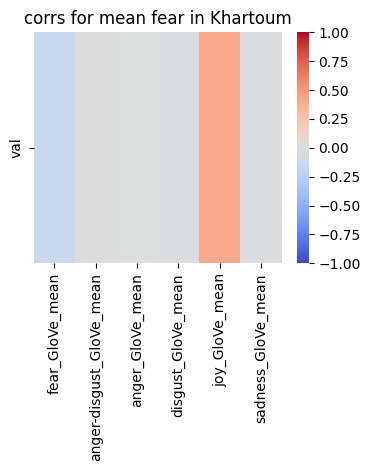

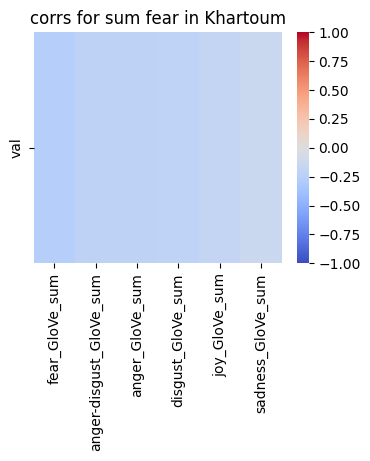

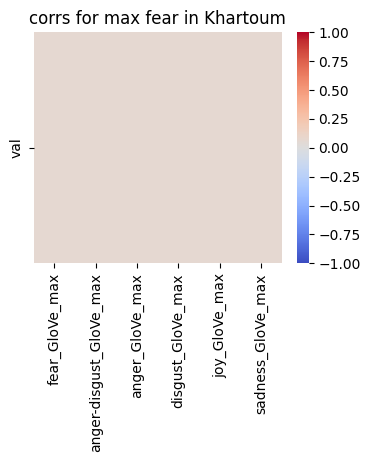

In [180]:
options = ["all"]+list(h2_df["location"].unique())
emo_agg = ["mean","sum","max"]

def output_h2(df, i):
    for agg in emo_agg:
        columns = sorted([col for col in df.columns if agg in col])
        fear = [col for col in columns if "fear" in col]
        ow = [col for col in columns if col not in fear]

        plt.figure(figsize=(4, 3))
        sns.heatmap(df[fear+ow].astype(float), annot=False, cmap='coolwarm', vmin=-1, vmax=1)   
        plt.title(f'corrs for {agg} fear in {options[i]}')
        plt.show()

i=7
output_h2(h2_corrMats[options[i]], i)

## Hypothesis 3: Negative sentiment does not capture fear.
#### Author: Bernardo
#### Test: Low correlation between emotions and sentiments (particularly negative sentiment vs. fear).
#### Evidence Against: High correlation between fear and negative sentiment. Low correlation between other negative emotions and negative sentiment.

In [181]:
senti_model = "multiBERT"
emo_model = "GloVe"

h3_in = in_m[["location"]+[col for col in in_m.columns if senti_model in col or emo_model in col]]
h3_out = out_m[["location"]+[col for col in out_m.columns if senti_model in col or emo_model in col]]
h3_df = pd.concat([h3_in, h3_out])
h3_df

,location,sentiment_multiBERT_mean,anger_GloVe_mean,fear_GloVe_mean,sadness_GloVe_mean,disgust_GloVe_mean,joy_GloVe_mean,anger-disgust_GloVe_mean,sentiment_multiBERT_sum,anger_GloVe_sum,...,disgust_GloVe_sum,joy_GloVe_sum,anger-disgust_GloVe_sum,sentiment_multiBERT_max,anger_GloVe_max,fear_GloVe_max,sadness_GloVe_max,disgust_GloVe_max,joy_GloVe_max,anger-disgust_GloVe_max
0,Aj Jazirah,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Aj Jazirah,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Aj Jazirah,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Aj Jazirah,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Aj Jazirah,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,White Nile,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
284,White Nile,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
285,White Nile,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
286,White Nile,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [182]:
h3_senti = sorted([col for col in h3_df.columns if senti_model in col])
h3_emo = sorted([col for col in h3_df.columns if emo_model in col])

h3_corrMats = {loc: corrMat(h3_emo, h3_senti, df) for loc, df in h3_df.groupby("location")}
h3_corrMats["all"] = corrMat(h3_emo, h3_senti, h3_df)

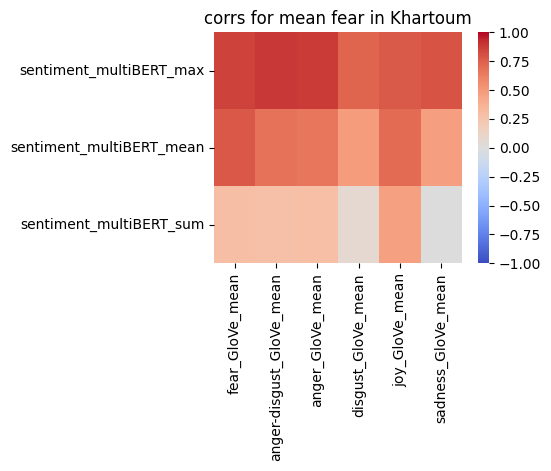

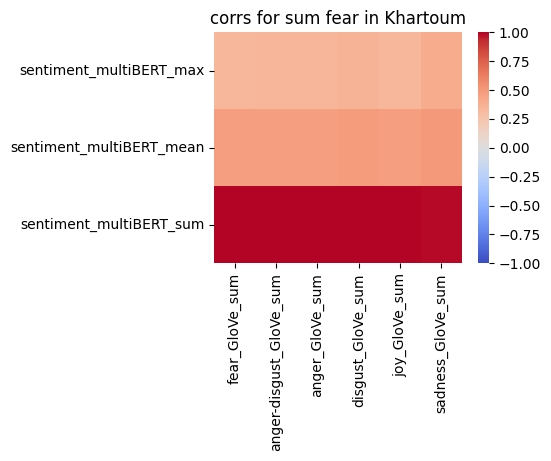

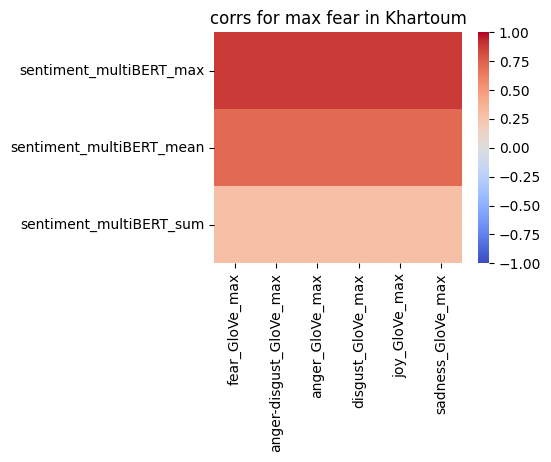

In [183]:
options = ["all"]+list(h3_df["location"].unique())

def output_h3(df, i):
    for agg in emo_agg:
        columns = sorted([col for col in df.columns if agg in col])
        fear = [col for col in columns if "fear" in col]
        ow = [col for col in columns if col not in fear]

        plt.figure(figsize=(4, 3))
        sns.heatmap(df[fear+ow].astype(float), annot=False, cmap='coolwarm', vmin=-1, vmax=1)   
        plt.title(f'corrs for {agg} fear in {options[i]}')
        plt.show()

i=7
output_h3(h3_corrMats[options[7]], i)

## Hypothesis 4: High levels of joy will correlate with less movement compared to any other emotion, regardless of language
#### Author: Mattea
#### Test: Correlations between emotions and flow data, focusing on differences between countries where certain languages are spoken 
#### Evidence Against: Joy has higher or similar correlation with movement than other emotions. Certain languages have different correlations that others do not